In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *
from analytical_solution import *

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres

## Boundary

In [30]:
nf = (2**2+1)**2
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

## Interior

In [31]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = (2**5+1)**2

uh = assembled_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='TPS')

domain = create_domain(uh.Mi, radius=0.35, c_y=0.5, c_x=0.5)

#unit_square
#circle_centre

uh.Mi, new_boundary = domain.setup(domain='unit_square', bound_points=12)
uh.Mb = np.vstack((uh.Mb, new_boundary))
uh.ni = uh.Mi.shape[0]
uh.nb = uh.Mb.shape[0]
X0 = uh.X_0()

In [32]:
boundary_points = pd.DataFrame(uh.Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

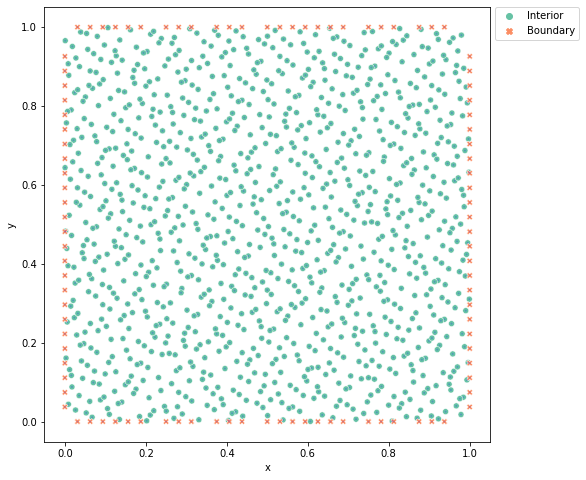

In [33]:
points = pd.concat([interior_points, boundary_points])

stable = stabillity(Mb, npnts)
qx = stable.qX()

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation',
                style='Collocation', palette='Set2')
for hk in points[['x', 'y']].values:
    c = plt.Circle(hk, qx, fill=False, alpha=0.2, color='b')
    ax.add_patch(c)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);

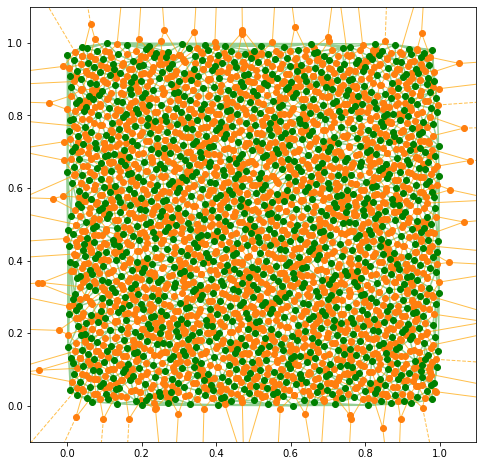

In [34]:
tri = Delaunay(uh.Mi)
vor = Voronoi(uh.Mi)

fig, axs = plt.subplots(figsize=(8, 8))
g = voronoi_plot_2d(vor, ax=axs, line_colors='orange', line_alpha=0.7)
plt.triplot(uh.Mi[:, 0], uh.Mi[:, 1], tri.simplices, alpha=0.5)
plt.plot(uh.Mi[:, 0], uh.Mi[:, 1], 'o', color='g')
plt.show()


In [35]:
print("Interior points: {:,.0f} \nBoundary points: {:,.0f} \nTotal points: {:,.0f}".format(uh.Mi.shape[0], uh.Mb.shape[0], uh.Mi.shape[0] + uh.Mb.shape[0]))

Interior points: 1,089 
Boundary points: 100 
Total points: 1,189


In [36]:
#uh.epsilon = 5.956
cond = np.linalg.cond(uh.ACaps())
det = np.linalg.det(uh.ACaps())
print('Condition number: {:,.0f} \nDeterminant: {:,.9f}'.format(cond, det))

Condition number: 168 
Determinant: -173,789,008,662,482,993,692,016,640.000000000


## Solve Matrix RK-Newthon

In [37]:
# Y = np.vstack((X0, X0))
# dt = 0.01
# uh.variables(X0, dt, Y)
#rr = uh.Rk(0.02)

In [38]:
# np.linalg.norm(Y, 'fro')

In [39]:
# for _ in range(50):
#     A, b = uh.inexact_Newthon(0.01)
#     Sp = np.linalg.inv(A).dot(b)
#     Y =  Y - Sp
#     uh.Y = Y
#     print(np.linalg.norm(Y, 'fro'))

In [40]:
#uh.Y

In [41]:
t0, te = 0, 1
N = 20
X0 = uh.X_0()
uh.exact_solution = "2"
uh.nu = 0.1
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [42]:
exp_RK.solve()

In [ ]:
exp_RK.timegrid

In [ ]:
# def u(X, t, nu):
#     x = X[:, 0]
#     y = X[:, 1]
#     u = 3/4 - 1/4 * (1/(1 + np.exp((4*y - 4*x - t)/(nu*32))))
#     v = 3/4 + 1/4 * (1/(1 + np.exp((4*y - 4*x - t)/(nu*32))))
#     return np.hstack((u.reshape(-1, 1), v.reshape(-1, 1)))

In [ ]:
#norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1, 1)
sol = exact_solution(uh.Mi, uh.nu)
n = exp_RK.solution.shape[0]
error = list()
for t in exp_RK.timegrid[1:]:
    ei = np.sqrt(np.linalg.norm(sol.u(t).round(3)-exp_RK.solution[int(t*N)].round(3))/n)
    error.append(ei)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(exp_RK.timegrid[1:], error)
plt.xlabel("$t$")
plt.ylabel("RMSE")
#ax.set_yscale('log')
#ax.set_xscale('log')

In [ ]:
# u_h = exp_RK.solution[25]
# u_h = np.vstack((u_h, u(uh.Mb, 0.5, uh.nu)))

In [ ]:
# import matplotlib.tri as tri
# from matplotlib import cm
# from scipy.interpolate import griddata

# X = np.vstack((uh.Mi, uh.Mb))
# x = X[:,0]
# y = X[:,1]
# z = u_h[:,0]

# fig = plt.figure(figsize=plt.figaspect(0.5))
# ax = fig.add_subplot(1, 2, 1, projection='3d')

# xi = np.linspace(x.min(),x.max(),100)
# yi = np.linspace(y.min(),y.max(),100)
# # VERY IMPORTANT, to tell matplotlib how is your data organized
# zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

# CS = plt.contour(xi,yi,zi,15,linewidths=0.5,color='k')
# ax = fig.add_subplot(1, 2, 2, projection='3d')

# xig, yig = np.meshgrid(xi, yi)

# surf = ax.plot_surface(xig, yig, zi,
#         linewidth=0)

# plt.show()
# ax.contour(xi, yi, ui, levels=14, linewidths=0.5, colors='k')
# cntr1 = ax.contourf(xi, yi, ui, levels=14, cmap="RdBu_r")

# #fig.colorbar(cntr1, ax=ax)
# ax.plot(x, y, 'ko', ms=3)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# ax.set_title('grid and contour (%d points, %d grid points)' %
#               (uh.ni, uh.ni * uh.ni))

# ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# cntr2 = ax.tricontourf(x, y, z, levels=14, cmap="RdBu_r")

# fig.colorbar(cntr2, ax=ax)
# ax.plot(x, y, 'ko', ms=3)
# ax.set(xlim=(0, 1), ylim=(0, 1))
# ax.set_title('tricontour (%d points)' % uh.ni)


In [ ]:
sol_dict = {}
for ti in range(exp_RK.solution.shape[0]):
    sol_dict[str(ti/100)] = str(exp_RK.solution[ti])

In [ ]:
import json

with open("solution_47i_46b_50t_circle_centre.json", 'w') as outf:
    json.dump(sol_dict, outf)

## Exact solution

In [ ]:
norm_x = np.linalg.norm(uh.Mi, axis=1).reshape(-1,1)
ni = uh.Mi.shape[0]
u0= u(uh.Mi, norm_x, 0.)
u0 = np.hstack((u0, np.array([0.]*ni).reshape(-1,1)))
for t in exp_RK.timegrid[1:]:
    ui= u(uh.Mi, norm_x, t)
    ui = np.hstack((ui, np.array([t]*ni).reshape(-1,1)))
    u0 = np.vstack((u0, ui))

exact_sol = plot_solution(u0, uh.Mi, 0)

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 1, 0.025)
Y = np.arange(0, 1, 0.025)
n_X = np.linalg.norm(np.hstack((X.reshape(-1,1), Y.reshape(-1,1))), axis=1).reshape(-1,1)
X, Y = np.meshgrid(X, Y)
t=0.05
V = Y/((1+t) + (1+t)*np.exp(n_X/(4*(1+t))))

# Plot the surface.
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [ ]:
L, H = np.pi*np.mgrid[-1:1:1000j, -1:1:1000j]
T = np.cos(L)*np.cos(2*H)
H = np.cos(L) + H
fig, ax = plt.subplots()
surf = plt.contourf(L, H, T, cmap="hot")
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [ ]:
L, H = np.pi*np.mgrid[-1:1:10j, -1:1:10j]
L

In [ ]:
ti = exact_sol.t.unique()[5]
sol_i = exact_sol[exact_sol['t'] == ti][['u', 'v']].values

In [ ]:
app_u_i = X0 + ti*Fm(X0, uh)
np.mean(abs(sol_i- app_u_i)[:,0])

## Solution

In [ ]:
sol = FDM_time(timegrid, X0, uh)
for t, s in sol.items():
    print('Time: {:,.4f}'.format(t))
    print(s, '\n')